Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [40]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

## For plotting

import matplotlib.pyplot as plt
%matplotlib inline


First reload the data we generated in _notmist.ipynb_.

In [3]:
pickle_file = '/Users/naqqashabbassi/Documents/Machine_Learning_Datasets/Udacity/Deep_Learning/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [11]:
train_dataset.shape

(200000, 784)

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### Regularization for a normal logistic regression implementation from Assignment 2 with SGD


In [39]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
    
  beta_regularlization = tf.placeholder(tf.float32)
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))+ beta_regularlization * tf.nn.l2_loss(weights)
  
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction =  tf.nn.softmax(tf.matmul(tf_test_dataset, weights)  + biases)
    
    
    
#############################################################################################################

num_steps = 3001


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,beta_regularlization : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 18.770330
Minibatch accuracy: 11.7%
Validation accuracy: 11.8%
Minibatch loss at step 500: 2.473430
Minibatch accuracy: 81.2%
Validation accuracy: 76.2%
Minibatch loss at step 1000: 1.815637
Minibatch accuracy: 81.2%
Validation accuracy: 78.6%
Minibatch loss at step 1500: 0.981581
Minibatch accuracy: 81.2%
Validation accuracy: 79.8%
Minibatch loss at step 2000: 0.859596
Minibatch accuracy: 87.5%
Validation accuracy: 80.6%
Minibatch loss at step 2500: 0.806492
Minibatch accuracy: 78.9%
Validation accuracy: 81.5%
Minibatch loss at step 3000: 0.774936
Minibatch accuracy: 84.4%
Validation accuracy: 81.9%
Test accuracy: 88.9%


In [80]:
num_steps = 3001
regul_val = [0,0.001,0.002,0.003,0.004,0.005]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print("Initialized with beta value of ",regul)
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,beta_regularlization : regul}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Initialized with beta value of  0
Initialized with beta value of  0.001
Initialized with beta value of  0.002
Initialized with beta value of  0.003
Initialized with beta value of  0.004
Initialized with beta value of  0.005


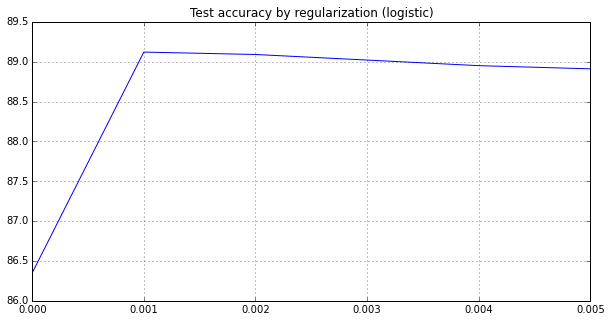

In [81]:
plt.figure(figsize=(10,5))
plt.plot(regul_val,accuracy_val)

plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()




In [107]:
num_steps = 3001
regul_val = [0,0.001,0.002,0.003,0.004,0.005]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print("Initialized with beta value of ",regul)
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,beta_regularlization : regul}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Initialized with beta value of  0


KeyboardInterrupt: 

After plotting the result it is obvious that the value of beta = 0.001 is the most suitable for the model. This value can be now used for the 1 hidden layer model. 

### Regularization for a normal 1-layer NN implementation from Assignment 2 with SGD


In [88]:
no_of_nodes = 1024
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    #Initializing the placeholder for the dataset
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset  = tf.constant(test_dataset)
    ## variable for the regularization
  beta_regularlization_nn = tf.placeholder(tf.float32)



    # Init weights and bias for the hidden layer 
  hidden_layer_weights = tf.Variable(tf.truncated_normal([image_size * image_size , no_of_nodes]))
  hidden_layer_bias    = tf.Variable(tf.zeros([no_of_nodes]))

      # Init weights and bias for the output layer
  output_layer_weights = tf.Variable(tf.truncated_normal([no_of_nodes , num_labels]))
  output_layer_bias    = tf.Variable(tf.zeros([num_labels]))

    # Hidden layer using relu
  hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_layer_weights)+hidden_layer_bias) 
    # Calculating the logits
  logits = tf.matmul(hidden_layer,output_layer_weights) + output_layer_bias
    # The loss using cross entropy and softmax
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits , tf_train_labels)) +\
                beta_regularlization_nn * (tf.nn.l2_loss(hidden_layer_weights) + tf.nn.l2_loss(output_layer_weights))

    # Optimizer using GradientDesent
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

  train_prediction = tf.nn.softmax(logits)

  # Setup validation prediction step.        
  valid_hidden_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_layer_weights) + hidden_layer_bias)       
  valid_logits = tf.matmul(valid_hidden_layer, output_layer_weights) + output_layer_bias
  valid_prediction = tf.nn.softmax(valid_logits)

  # And setup the test prediction step.
  test_hidden_layer = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_layer_weights) + hidden_layer_bias)
  test_logits = tf.matmul(test_hidden_layer, output_layer_weights) + output_layer_bias
  test_prediction = tf.nn.softmax(test_logits)

In [90]:
num_steps = 3001
training_accuracy = []
validation_accuracy = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regularlization_nn : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step", step, ":", l)
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
      training_accuracy.append(accuracy(predictions, batch_labels))
      validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0 : 670.021
Minibatch accuracy: 10.9%
Validation accuracy: 23.5%
Minibatch loss at step 500 : 199.045
Minibatch accuracy: 80.5%
Validation accuracy: 79.6%
Minibatch loss at step 1000 : 116.287
Minibatch accuracy: 80.5%
Validation accuracy: 81.5%
Minibatch loss at step 1500 : 68.8357
Minibatch accuracy: 88.3%
Validation accuracy: 82.7%
Minibatch loss at step 2000 : 41.219
Minibatch accuracy: 89.8%
Validation accuracy: 84.9%
Minibatch loss at step 2500 : 25.147
Minibatch accuracy: 85.9%
Validation accuracy: 85.7%
Minibatch loss at step 3000 : 15.4786
Minibatch accuracy: 87.5%
Validation accuracy: 86.5%
Test accuracy: 93.1%


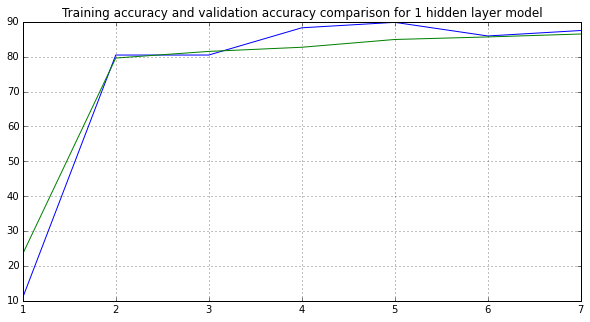

In [105]:
x = np.arange(1,8)
plt.figure(figsize=(10,5))

plt.plot(x,training_accuracy,x,validation_accuracy)
plt.axis([1,7,10,90])

plt.grid(True)
plt.title('Training accuracy and validation accuracy comparison for 1 hidden layer model')
plt.show()


In [111]:
num_steps = 3001
regul_val = [0.001,0.002,0.003]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()
      print("Initialized with beta value of ",regul)
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,beta_regularlization_nn : regul}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

Initialized with beta value of  0.001
Initialized with beta value of  0.002
Initialized with beta value of  0.003


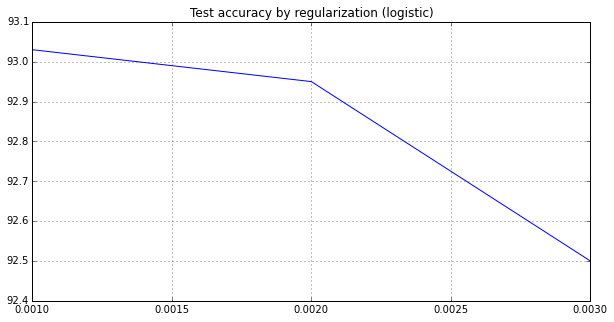

In [112]:
plt.figure(figsize=(10,5))
plt.plot(regul_val,accuracy_val)

plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

It is obvious from the above plot, that the best value of beta is 0.001 as expected.

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [163]:
no_of_nodes = 1024


graph = tf.Graph()
with graph.as_default():

    #Initializing the placeholder for the dataset
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset  = tf.constant(test_dataset)
    ## variable for the regularization
  beta_regularlization_nn = tf.placeholder(tf.float32)



    # Init weights and bias for the hidden layer 
  hidden_layer_weights = tf.Variable(tf.truncated_normal([image_size * image_size , no_of_nodes]))
  hidden_layer_bias    = tf.Variable(tf.zeros([no_of_nodes]))

      # Init weights and bias for the output layer
  output_layer_weights = tf.Variable(tf.truncated_normal([no_of_nodes , num_labels]))
  output_layer_bias    = tf.Variable(tf.zeros([num_labels]))

    # Hidden layer using relu
  hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_layer_weights)+hidden_layer_bias) 
    # Calculating the logits
  logits = tf.matmul(hidden_layer,output_layer_weights) + output_layer_bias
    # The loss using cross entropy and softmax
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits , tf_train_labels)) +\
                beta_regularlization_nn * (tf.nn.l2_loss(hidden_layer_weights) + tf.nn.l2_loss(output_layer_weights))

    # Optimizer using GradientDesent
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

  train_prediction = tf.nn.softmax(logits)

  # Setup validation prediction step.        
  valid_hidden_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_layer_weights) + hidden_layer_bias)       
  valid_logits = tf.matmul(valid_hidden_layer, output_layer_weights) + output_layer_bias
  valid_prediction = tf.nn.softmax(valid_logits)

  # And setup the test prediction step.
  test_hidden_layer = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_layer_weights) + hidden_layer_bias)
  test_logits = tf.matmul(test_hidden_layer, output_layer_weights) + output_layer_bias
  test_prediction = tf.nn.softmax(test_logits)
    
    
num_steps = 100
batch_size = 5
training_accuracy = []
validation_accuracy = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step % batch_size) 
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regularlization_nn : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 10 == 0):
      print("Minibatch loss at step", step, ":", l)
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
      training_accuracy.append(accuracy(predictions, batch_labels))
      validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))




Initialized
Minibatch loss at step 0 : 666.753
Minibatch accuracy: 0.0%
Validation accuracy: 14.5%
Minibatch loss at step 10 : 1079.64
Minibatch accuracy: 80.0%
Validation accuracy: 19.4%
Minibatch loss at step 20 : 360.356
Minibatch accuracy: 100.0%
Validation accuracy: 21.6%
Minibatch loss at step 30 : 356.77
Minibatch accuracy: 100.0%
Validation accuracy: 21.6%
Minibatch loss at step 40 : 353.219
Minibatch accuracy: 100.0%
Validation accuracy: 21.6%
Minibatch loss at step 50 : 349.703
Minibatch accuracy: 100.0%
Validation accuracy: 21.6%
Minibatch loss at step 60 : 346.223
Minibatch accuracy: 100.0%
Validation accuracy: 21.6%
Minibatch loss at step 70 : 342.777
Minibatch accuracy: 100.0%
Validation accuracy: 21.5%
Minibatch loss at step 80 : 339.366
Minibatch accuracy: 100.0%
Validation accuracy: 21.5%
Minibatch loss at step 90 : 335.988
Minibatch accuracy: 100.0%
Validation accuracy: 21.5%
Test accuracy: 22.4%


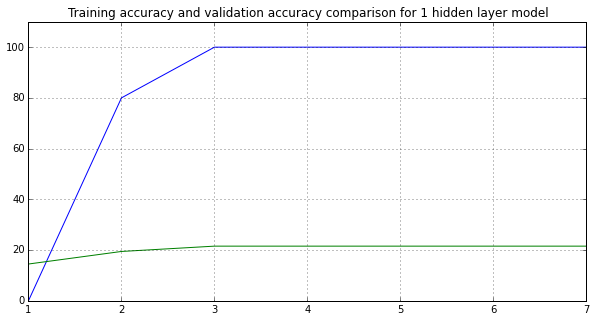

In [164]:
x = np.arange(1,len(training_accuracy)+1)
plt.figure(figsize=(10,5))

plt.plot(x,training_accuracy,x,validation_accuracy)
plt.axis([1,7,0,110])

plt.grid(True)
plt.title('Training accuracy and validation accuracy comparison for 1 hidden layer model')
plt.show()

We can clearly see the extreme case of overfitting when we limit out batch size

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [165]:
no_of_nodes = 1024


graph = tf.Graph()
with graph.as_default():

    #Initializing the placeholder for the dataset
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset  = tf.constant(test_dataset)
    ## variable for the regularization
  beta_regularlization_nn = tf.placeholder(tf.float32)



    # Init weights and bias for the hidden layer 
  hidden_layer_weights = tf.Variable(tf.truncated_normal([image_size * image_size , no_of_nodes]))
  hidden_layer_bias    = tf.Variable(tf.zeros([no_of_nodes]))

      # Init weights and bias for the output layer
  output_layer_weights = tf.Variable(tf.truncated_normal([no_of_nodes , num_labels]))
  output_layer_bias    = tf.Variable(tf.zeros([num_labels]))

  
    # Hidden layer using relu
  hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_layer_weights)+hidden_layer_bias) 
  drop_out_l1 = tf.nn.dropout(hidden_layer, 0.5)
    # Calculating the logits
  logits = tf.matmul(drop_out_l1,output_layer_weights) + output_layer_bias
    # The loss using cross entropy and softmax
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits , tf_train_labels)) +\
                beta_regularlization_nn * (tf.nn.l2_loss(hidden_layer_weights) + tf.nn.l2_loss(output_layer_weights))

    # Optimizer using GradientDesent
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

  train_prediction = tf.nn.softmax(logits)

  # Setup validation prediction step.        
  valid_hidden_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_layer_weights) + hidden_layer_bias)       
  valid_logits = tf.matmul(valid_hidden_layer, output_layer_weights) + output_layer_bias
  valid_prediction = tf.nn.softmax(valid_logits)

  # And setup the test prediction step.
  test_hidden_layer = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_layer_weights) + hidden_layer_bias)
  test_logits = tf.matmul(test_hidden_layer, output_layer_weights) + output_layer_bias
  test_prediction = tf.nn.softmax(test_logits)
    
    
num_steps = 101
batch_size = 5
training_accuracy = []
validation_accuracy = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step % batch_size) 
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regularlization_nn : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 10 == 0):
      print("Minibatch loss at step", step, ":", l)
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
      training_accuracy.append(accuracy(predictions, batch_labels))
      validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))



Initialized
Minibatch loss at step 0 : 793.893
Minibatch accuracy: 20.0%
Validation accuracy: 14.9%
Minibatch loss at step 10 : 153712.0
Minibatch accuracy: 60.0%
Validation accuracy: 13.3%
Minibatch loss at step 20 : 1.50438e+07
Minibatch accuracy: 40.0%
Validation accuracy: 11.8%
Minibatch loss at step 30 : 2.29254e+07
Minibatch accuracy: 60.0%
Validation accuracy: 16.0%
Minibatch loss at step 40 : 4.07516e+08
Minibatch accuracy: 0.0%
Validation accuracy: 17.3%
Minibatch loss at step 50 : 2.15249e+10
Minibatch accuracy: 40.0%
Validation accuracy: 10.9%
Minibatch loss at step 60 : 2.42734e+11
Minibatch accuracy: 20.0%
Validation accuracy: 16.7%
Minibatch loss at step 70 : 2.08566e+12
Minibatch accuracy: 20.0%
Validation accuracy: 13.7%
Minibatch loss at step 80 : 8.21652e+12
Minibatch accuracy: 20.0%
Validation accuracy: 16.2%
Minibatch loss at step 90 : 1.82357e+12
Minibatch accuracy: 40.0%
Validation accuracy: 17.3%
Minibatch loss at step 100 : 6.51188e+12
Minibatch accuracy: 40.0%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---




### 2 hidden layer model with regularization

In [172]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  ## variable for the regularization
  beta_regularlization_nn = tf.placeholder(tf.float32)

  # Variables.
  weights1 = tf.Variable(tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    
    
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  logits = tf.matmul(lay2_train, weights3) + biases3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
      beta_regulularization_nn * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [173]:
num_steps = 3001
training_accuracy = []
validation_accuracy = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regularlization_nn : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step", step, ":", l)
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
      training_accuracy.append(accuracy(predictions, batch_labels))
      validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0 : 3.35458
Minibatch accuracy: 7.0%
Validation accuracy: 23.3%
Minibatch loss at step 500 : 0.939529
Minibatch accuracy: 88.3%
Validation accuracy: 85.6%
Minibatch loss at step 1000 : 0.875601
Minibatch accuracy: 85.9%
Validation accuracy: 86.6%
Minibatch loss at step 1500 : 0.544009
Minibatch accuracy: 93.0%
Validation accuracy: 87.8%
Minibatch loss at step 2000 : 0.51685
Minibatch accuracy: 93.8%
Validation accuracy: 88.0%
Minibatch loss at step 2500 : 0.525977
Minibatch accuracy: 90.6%
Validation accuracy: 88.5%
Minibatch loss at step 3000 : 0.554578
Minibatch accuracy: 89.1%
Validation accuracy: 88.6%
Test accuracy: 94.7%


### Seem like with more layers and regularization the result is getting better
### Lets try 3 hidden layers with regularization 

In [191]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  beta_regularlization_nn = tf.placeholder(tf.float32)
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  

  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  

  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
  logits = tf.matmul(lay3_train, weights4) + biases4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))+\
      beta_regularlization_nn * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3)+ tf.nn.l2_loss(weights4))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [183]:
num_steps = 20001
training_accuracy = []
validation_accuracy = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regularlization_nn : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2000 == 0):
      print("Minibatch loss at step", step, ":", l)
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
      training_accuracy.append(accuracy(predictions, batch_labels))
      validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0 : 3.42702
Minibatch accuracy: 16.4%
Validation accuracy: 37.2%
Minibatch loss at step 2000 : 0.540107
Minibatch accuracy: 92.2%
Validation accuracy: 87.7%
Minibatch loss at step 4000 : 0.437594
Minibatch accuracy: 93.0%
Validation accuracy: 88.4%
Minibatch loss at step 6000 : 0.587153
Minibatch accuracy: 85.9%
Validation accuracy: 88.8%
Minibatch loss at step 8000 : 0.644813
Minibatch accuracy: 82.8%
Validation accuracy: 89.0%
Minibatch loss at step 10000 : 0.428871
Minibatch accuracy: 89.8%
Validation accuracy: 89.7%
Minibatch loss at step 12000 : 0.473604
Minibatch accuracy: 89.8%
Validation accuracy: 89.9%
Minibatch loss at step 14000 : 0.421187
Minibatch accuracy: 92.2%
Validation accuracy: 90.6%
Minibatch loss at step 16000 : 0.35204
Minibatch accuracy: 93.8%
Validation accuracy: 90.3%
Minibatch loss at step 18000 : 0.311133
Minibatch accuracy: 95.3%
Validation accuracy: 90.5%
Minibatch loss at step 20000 : 0.443139
Minibatch accuracy: 89.8%
Va

### Trying four layers with regularization 

In [198]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
num_hidden_nodes4 = 64
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  beta_regularlization_nn = tf.placeholder(tf.float32)


  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  

  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  
  

  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_hidden_nodes4], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_hidden_nodes4]))
    
  weights5 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes4, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes4)))
  biases5 = tf.Variable(tf.zeros([num_labels]))
    
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
  lay4_train = tf.nn.relu(tf.matmul(lay3_train, weights4) + biases4)
  logits = tf.matmul(lay4_train, weights5) + biases5
  
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))+\
      beta_regularlization_nn * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3)+ tf.nn.l2_loss(weights4) + tf.nn.l2_loss(weights5))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  
    
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  lay4_valid = tf.nn.relu(tf.matmul(lay3_valid, weights4) + biases4)
  valid_prediction = tf.nn.softmax(tf.matmul(lay4_valid, weights5) + biases5)
  

  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  lay4_test = tf.nn.relu(tf.matmul(lay3_test, weights4) + biases4)
  test_prediction = tf.nn.softmax(tf.matmul(lay4_test, weights5) + biases5)

In [199]:
num_steps = 20001
training_accuracy = []
validation_accuracy = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regularlization_nn : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 2000 == 0):
        
      print("Minibatch loss at step", step, ":", l)
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    
      training_accuracy.append(accuracy(predictions, batch_labels))
      validation_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))
    
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0 : 3.55934
Minibatch accuracy: 11.7%
Validation accuracy: 20.6%
Minibatch loss at step 2000 : 0.539295
Minibatch accuracy: 91.4%
Validation accuracy: 87.8%
Minibatch loss at step 4000 : 0.47813
Minibatch accuracy: 90.6%
Validation accuracy: 88.1%
Minibatch loss at step 6000 : 0.61889
Minibatch accuracy: 85.9%
Validation accuracy: 88.3%
Minibatch loss at step 8000 : 0.611202
Minibatch accuracy: 85.9%
Validation accuracy: 88.8%
Minibatch loss at step 10000 : 0.422707
Minibatch accuracy: 90.6%
Validation accuracy: 89.6%
Minibatch loss at step 12000 : 0.483692
Minibatch accuracy: 89.8%
Validation accuracy: 89.8%
Minibatch loss at step 14000 : 0.412324
Minibatch accuracy: 93.0%
Validation accuracy: 90.3%
Minibatch loss at step 16000 : 0.339105
Minibatch accuracy: 95.3%
Validation accuracy: 90.4%
Minibatch loss at step 18000 : 0.317888
Minibatch accuracy: 96.1%
Validation accuracy: 90.7%
Minibatch loss at step 20000 : 0.417661
Minibatch accuracy: 90.6%
Val

### The best test accuracy I could achieve so far is 95.9% by using 3 layers and regularization.
